| meter\_type      | 주요 문제 원인                     | 관찰된 특징                                                                   | 가능 원인                                                   |
| ---------------- | ---------------------------- | ------------------------------------------------------------------------ | ------------------------------------------------------- |
| **electricity**  | 급격한 스파이크 구간 예측 실패, 전반적인 과소예측 | Truth vs Pred에서 스파이크 못 따라감, 산점도에서 y\_true ↑ 시 y\_pred 제한적, 잔차 분포 음수 꼬리 김 | 변동성이 큰 부하 패턴 학습 미흡, 이상치/이벤트 구간 데이터 부족, 입력 특성 부족(날씨·이벤트) |
| **chilledwater** | 변동 폭이 작음에도 일부 급격한 과소예측 발생    | Truth vs Pred에서 전체적으로 낮은 변동, 일부 딥 스파이크에서 예측치 유지 못함, 잔차 분포 좌측 꼬리          | 데이터 분포 불균형, 드물게 발생하는 피크 패턴 학습 미흡                        |
| **steam**        | 주기적 큰 음수 잔차, 고값 영역 예측 부족     | Truth vs Pred에서 고빈도 스파이크 발생, 산점도에서 y\_true 커질수록 예측 갭 발생, 잔차 주기적 급락       | 계절성·장주기 패턴 미반영, sequence length 부족, 가중치 불균형             |
| **hotwater**     | 변동 폭이 매우 작아 학습 의미 제한적        | Truth vs Pred에서 거의 평평, 산점도에서 한두 값 주변에 밀집, 잔차 분포 폭 매우 좁음                  | 실제 데이터 변동성이 낮음, 표준화 후 스케일 영향 과도                         |
| **gas**          | 변동성 거의 없음, 예측이 일정 값에 수렴      | Truth vs Pred에서 변화 거의 없음, 산점도에서 단일 값 밀집, 잔차 분포 거의 0                      | 데이터 스케일이 매우 작거나 변동성 부족, 모델 학습 영향 미미                     |


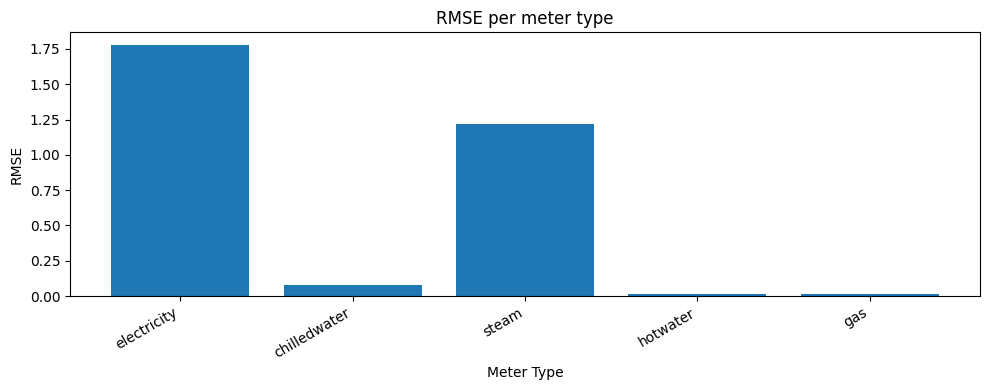

In [18]:

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_DIR = Path("../results")
PRED_CSV = RESULTS_DIR / "preds_all.csv"
POLICY_CSV = RESULTS_DIR / "policy_events_ready.csv"
METRICS_CSV = RESULTS_DIR / "metrics_per_meter.csv"

# CSV 로드
dfs = {}
if PRED_CSV.exists():
    dfs["preds"] = pd.read_csv(PRED_CSV)
if POLICY_CSV.exists():
    dfs["policy"] = pd.read_csv(POLICY_CSV)
if METRICS_CSV.exists():
    dfs["metrics"] = pd.read_csv(METRICS_CSV)

# 1. RMSE per meter bar chart
if "metrics" in dfs and not dfs["metrics"].empty:
    m = dfs["metrics"].copy()
    m["RMSE"] = pd.to_numeric(m["RMSE"], errors="coerce")
    plt.figure(figsize=(10, 4))
    plt.bar(m["meter_type"], m["RMSE"])
    plt.title("RMSE per meter type")
    plt.xlabel("Meter Type")
    plt.ylabel("RMSE")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


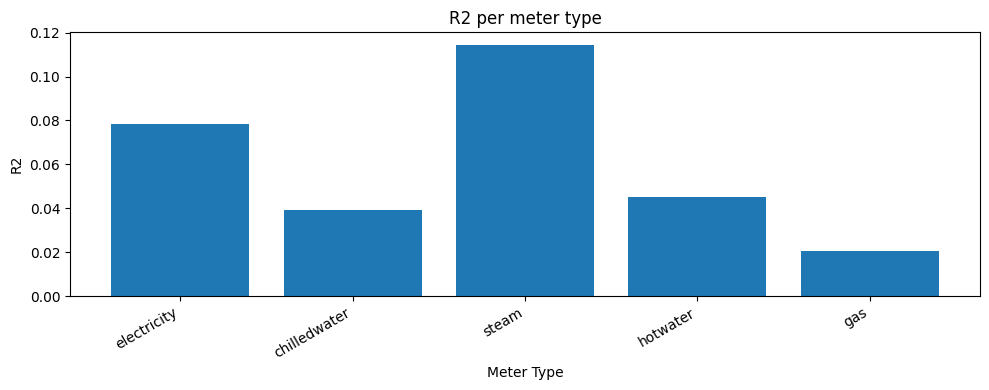

In [19]:

# 2. R2 per meter bar chart
if "metrics" in dfs and not dfs["metrics"].empty:
    m = dfs["metrics"].copy()
    m["R2"] = pd.to_numeric(m["R2"], errors="coerce")
    plt.figure(figsize=(10, 4))
    plt.bar(m["meter_type"], m["R2"])
    plt.title("R2 per meter type")
    plt.xlabel("Meter Type")
    plt.ylabel("R2")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


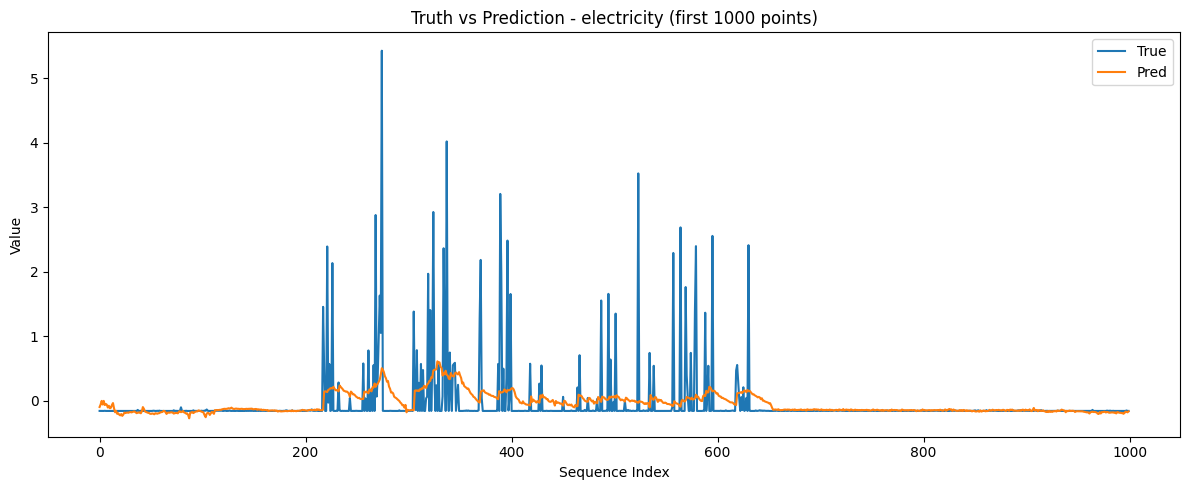

In [20]:

# 3. Truth vs Prediction for top meter
if "preds" in dfs and not dfs["preds"].empty:
    d = dfs["preds"].copy()
    top = d["meter_type"].value_counts().index.tolist()[0]
    dd = d[d["meter_type"] == top].sort_values("seq_index").reset_index(drop=True)
    window = min(1000, len(dd))
    ddw = dd.iloc[:window]
    plt.figure(figsize=(12, 5))
    plt.plot(ddw["seq_index"], ddw["y_true"], label="True")
    plt.plot(ddw["seq_index"], ddw["y_pred"], label="Pred")
    plt.title(f"Truth vs Prediction - {top} (first {window} points)")
    plt.xlabel("Sequence Index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


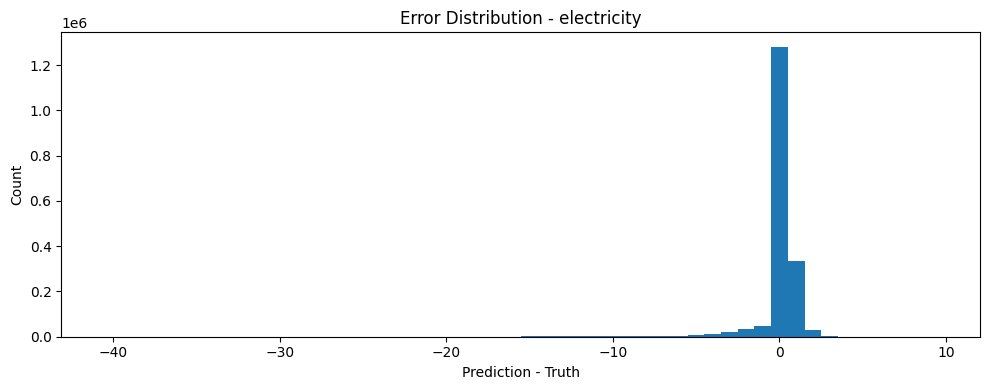

In [21]:

# 4. Error distribution for the same meter
if "preds" in dfs and not dfs["preds"].empty:
    err = dd["y_pred"] - dd["y_true"]
    plt.figure(figsize=(10, 4))
    plt.hist(err.dropna().values, bins=50)
    plt.title(f"Error Distribution - {top}")
    plt.xlabel("Prediction - Truth")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [22]:

# 5. Policy events sample
if "policy" in dfs and not dfs["policy"].empty:
    print("Policy events sample:")
    print(dfs["policy"].head(10))


Policy events sample:
                     timestamp  zone_id   meter_type     value  \
0  2025-08-11T16:25:17.139630Z  default  electricity -0.093230   
1  2025-08-11T16:26:17.139630Z  default  electricity -0.054367   
2  2025-08-11T16:27:17.139630Z  default  electricity  0.001660   
3  2025-08-11T16:28:17.139630Z  default  electricity -0.054987   
4  2025-08-11T16:29:17.139630Z  default  electricity  0.001509   
5  2025-08-11T16:30:17.139630Z  default  electricity -0.062761   
6  2025-08-11T16:31:17.139630Z  default  electricity -0.045613   
7  2025-08-11T16:32:17.139630Z  default  electricity -0.057983   
8  2025-08-11T16:33:17.139630Z  default  electricity -0.101282   
9  2025-08-11T16:34:17.139630Z  default  electricity -0.073787   

   indoor_temperature_pred  occupancy_pred  horizon  
0                      NaN             NaN        0  
1                      NaN             NaN        1  
2                      NaN             NaN        2  
3                      NaN         

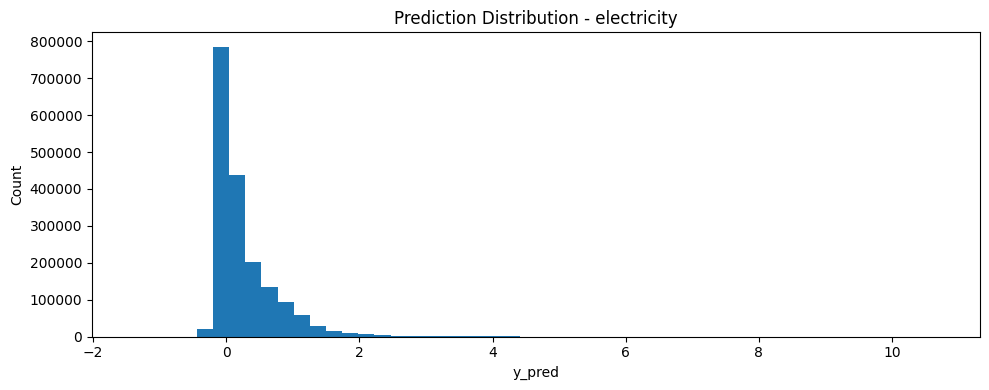

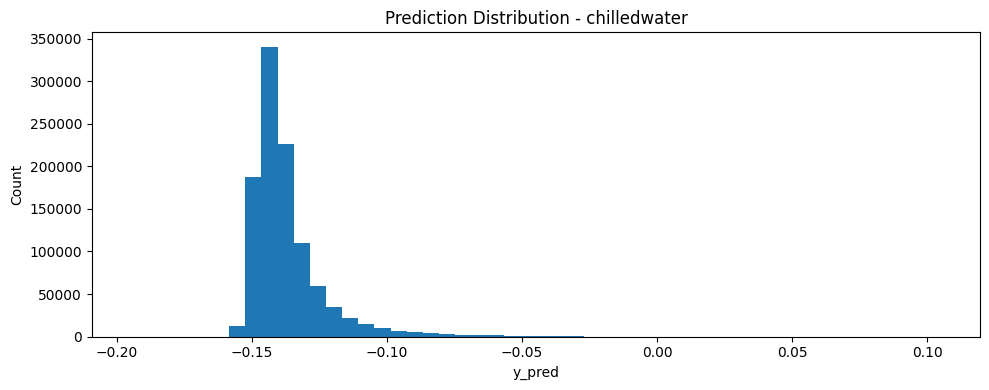

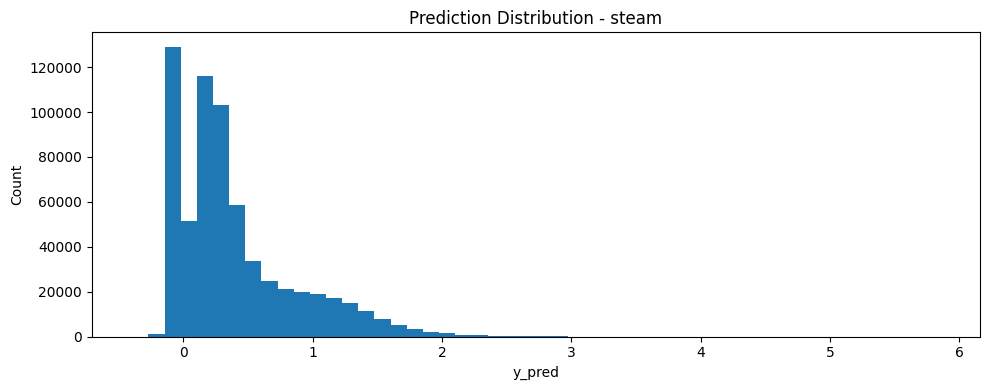

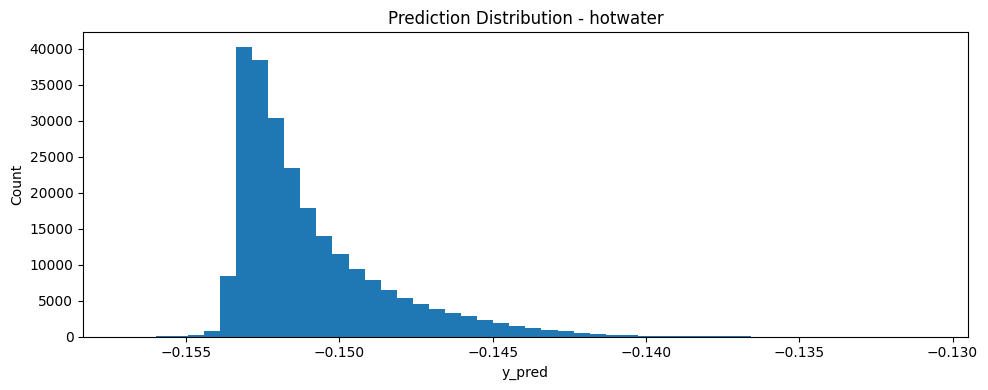

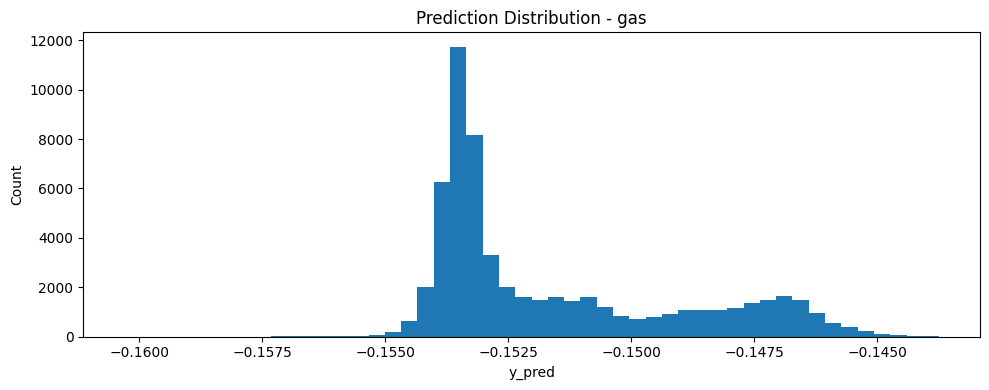

In [23]:

# 6. meter_type별 예측 분포 비교 그래프
if "preds" in dfs and not dfs["preds"].empty:
    meters = dfs["preds"]["meter_type"].unique()
    for m in meters:
        dm = dfs["preds"][dfs["preds"]["meter_type"] == m]
        plt.figure(figsize=(10, 4))
        plt.hist(dm["y_pred"].dropna().values, bins=50)
        plt.title(f"Prediction Distribution - {m}")
        plt.xlabel("y_pred")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


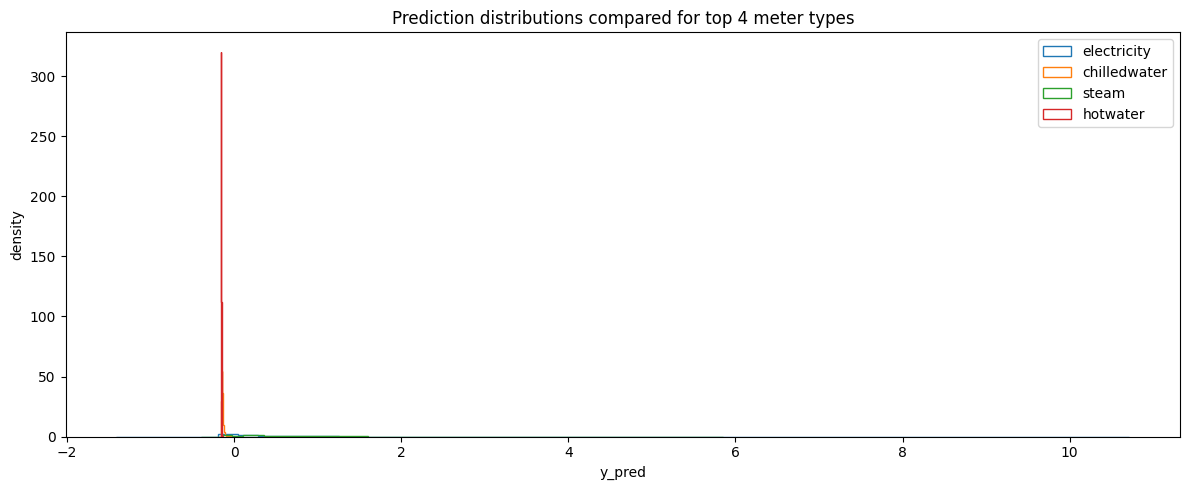

In [24]:

# 7. 여러 meter_type 예측 분포를 한 화면에서 비교하는 히스토그램
if "preds" in dfs and not dfs["preds"].empty:
    d = dfs["preds"].copy()
    # 데이터가 많은 순서로 상위 K개 meter_type 선택
    top_k = 4
    meters = d["meter_type"].value_counts().index.tolist()[:top_k]
    data_list = []
    labels = []
    for mtype in meters:
        vals = d.loc[d["meter_type"] == mtype, "y_pred"].dropna().values
        if len(vals) > 0:
            data_list.append(vals)
            labels.append(mtype)

    if len(data_list) >= 2:
        plt.figure(figsize=(12, 5))
        # 여러 분포를 한 Figure에 겹쳐서 표시
        # 밀도기반 비교를 위해 density=True 사용
        # bin 수는 자동 선택 또는 원하는 값으로 조정 가능
        for vals, lab in zip(data_list, labels):
            plt.hist(vals, bins=50, density=True, histtype="step", label=lab)
        plt.title(f"Prediction distributions compared for top {len(labels)} meter types")
        plt.xlabel("y_pred")
        plt.ylabel("density")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough meter types to compare on a single figure")


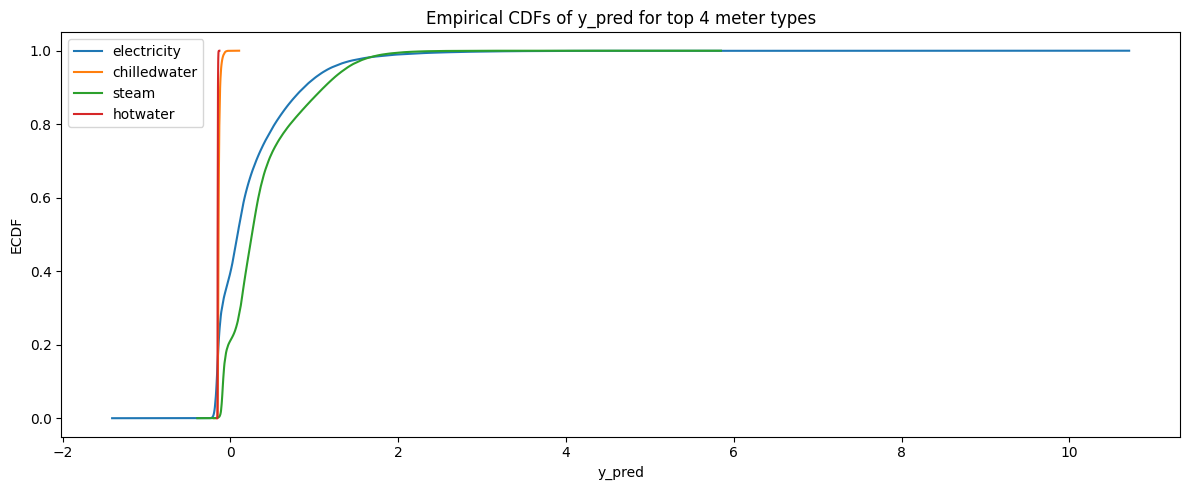

In [25]:

# 8. 여러 meter_type 예측 분포의 경험적 CDF 비교
if "preds" in dfs and not dfs["preds"].empty:
    d = dfs["preds"].copy()
    top_k = 4
    meters = d["meter_type"].value_counts().index.tolist()[:top_k]
    pairs = []
    for mtype in meters:
        vals = d.loc[d["meter_type"] == mtype, "y_pred"].dropna().values
        if len(vals) > 0:
            x = np.sort(vals)
            y = np.arange(1, len(x) + 1) / float(len(x))
            pairs.append((mtype, x, y))

    if len(pairs) >= 2:
        plt.figure(figsize=(12, 5))
        for mtype, x, y in pairs:
            plt.plot(x, y, label=mtype)
        plt.title(f"Empirical CDFs of y_pred for top {len(pairs)} meter types")
        plt.xlabel("y_pred")
        plt.ylabel("ECDF")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough meter types to compare ECDFs on a single figure")


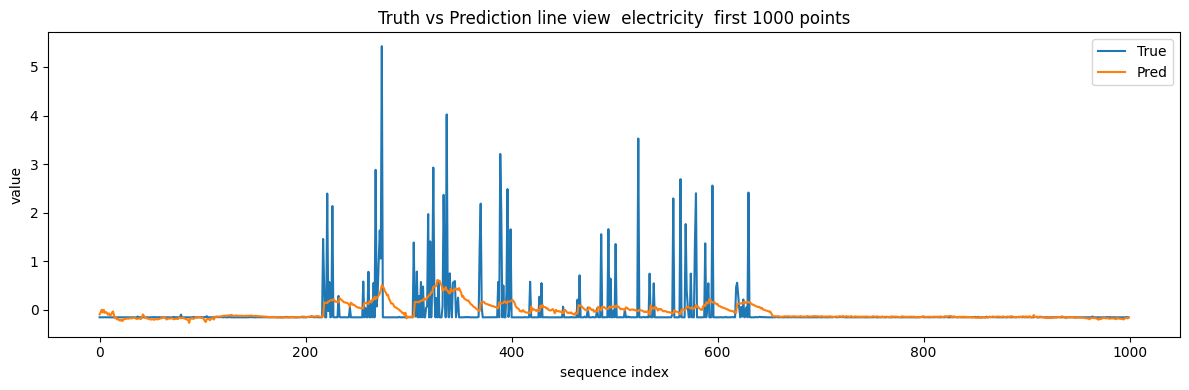

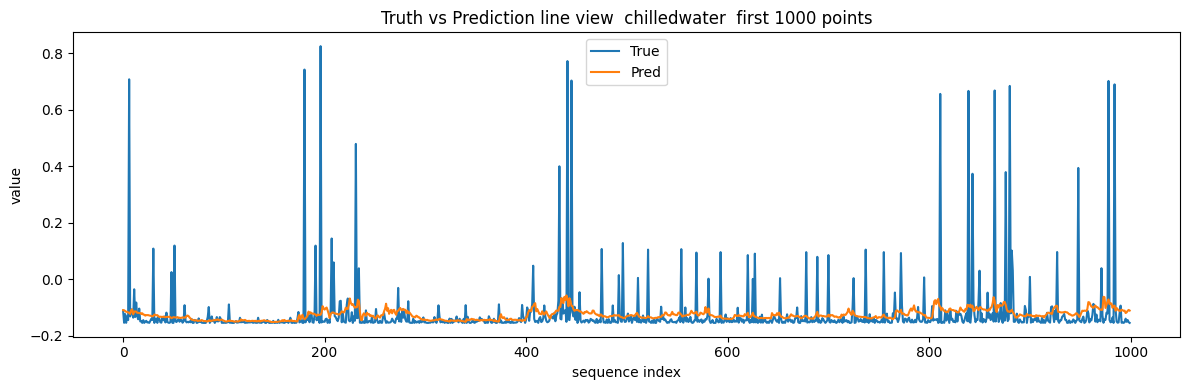

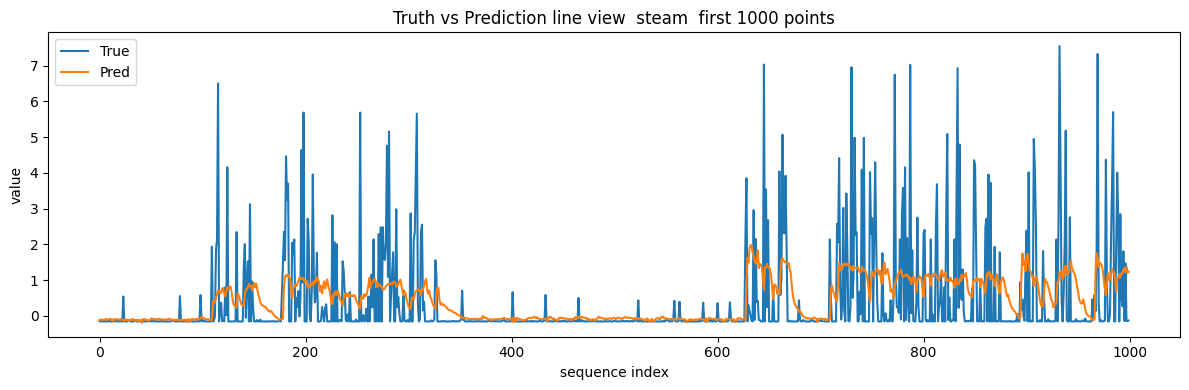

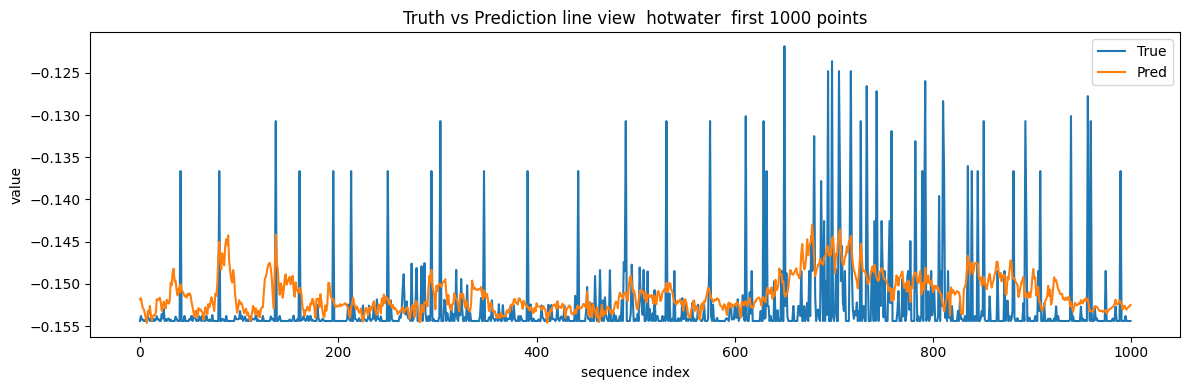

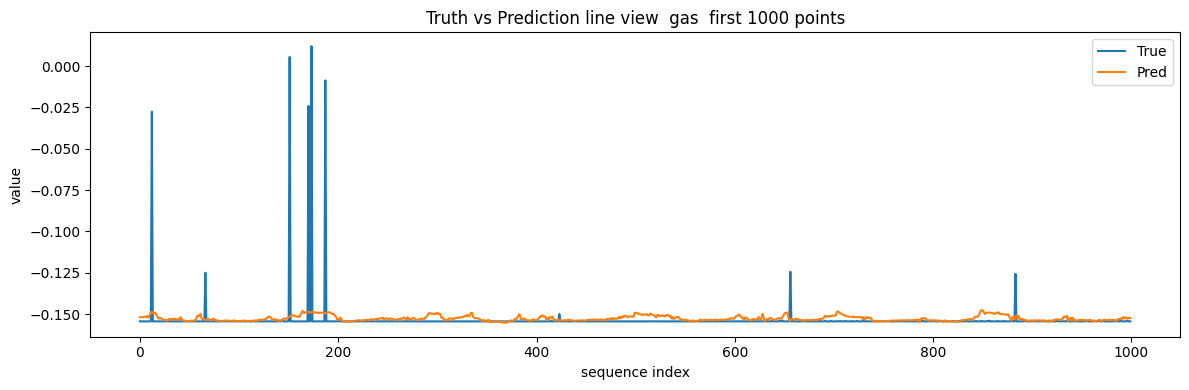

In [26]:
# 9. meter_type별 y_true vs y_pred 선그래프 샘플
# 각 meter별로 초반 window 구간만 라인 비교
if "preds" in dfs and not dfs["preds"].empty:
    d = dfs["preds"].copy()
    meters = d["meter_type"].unique()
    window = 1000
    for mtype in meters:
        dm = d[d["meter_type"] == mtype].sort_values("seq_index").reset_index(drop=True)
        if len(dm) == 0:
            continue
        w = min(window, len(dm))
        ddw = dm.iloc[:w]
        plt.figure(figsize=(12, 4))
        plt.plot(ddw["seq_index"], ddw["y_true"], label="True")
        plt.plot(ddw["seq_index"], ddw["y_pred"], label="Pred")
        plt.title(f"Truth vs Prediction line view  {mtype}  first {w} points")
        plt.xlabel("sequence index")
        plt.ylabel("value")
        plt.legend()
        plt.tight_layout()
        plt.show()


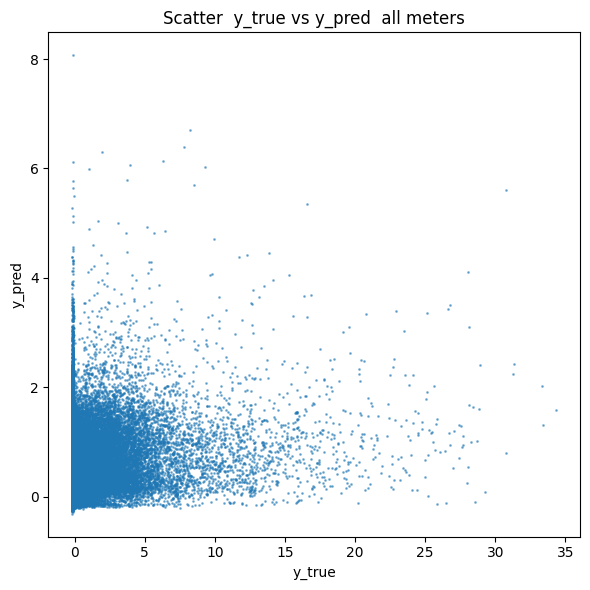

In [27]:
# 10. 전체 데이터 산점도 y_true vs y_pred
# 너무 크면 샘플링해서 그린다
if "preds" in dfs and not dfs["preds"].empty:
    d = dfs["preds"][["y_true", "y_pred"]].dropna()
    n = len(d)
    max_points = 200000
    if n > max_points:
        d = d.sample(max_points, random_state=42)
    plt.figure(figsize=(6, 6))
    plt.scatter(d["y_true"], d["y_pred"], s=1, alpha=0.5)
    plt.title("Scatter  y_true vs y_pred  all meters")
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.tight_layout()
    plt.show()


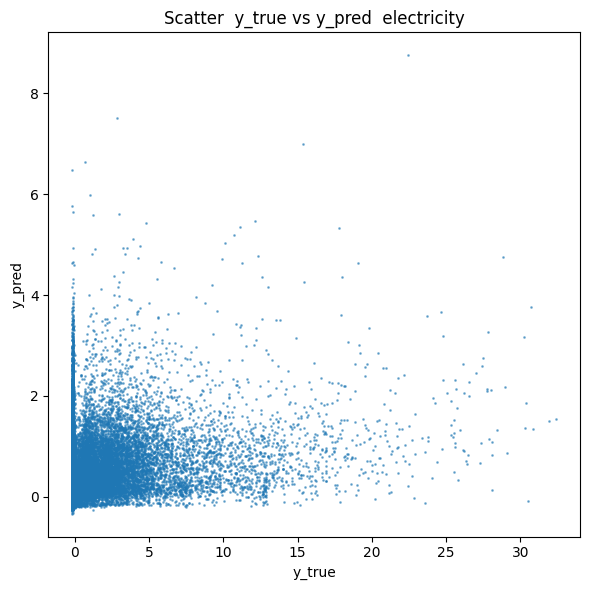

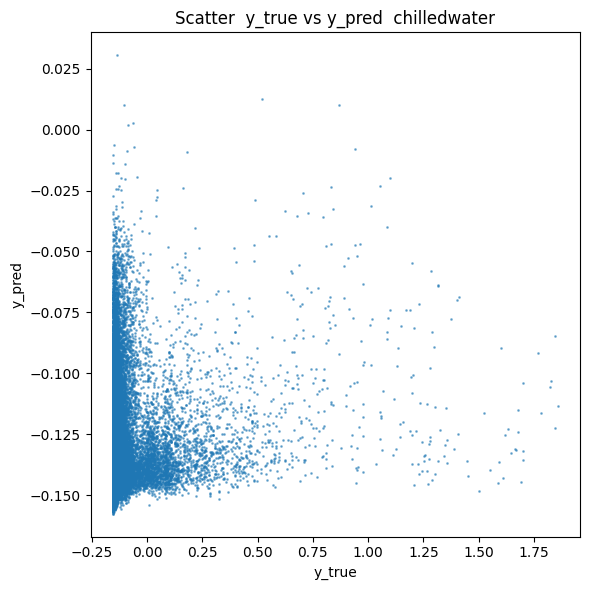

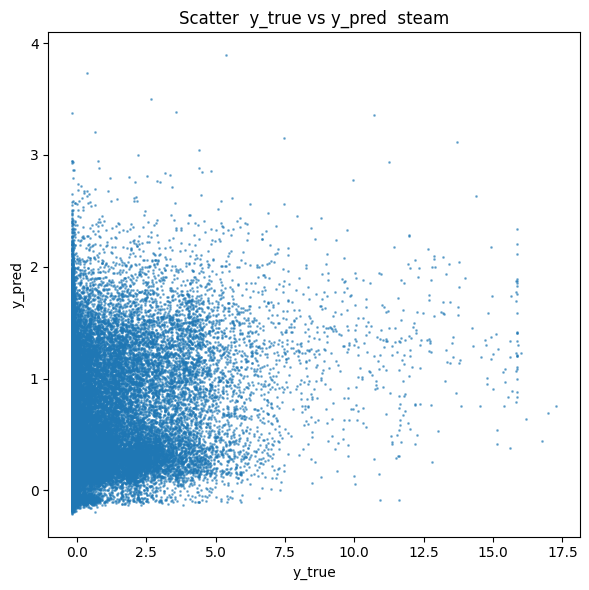

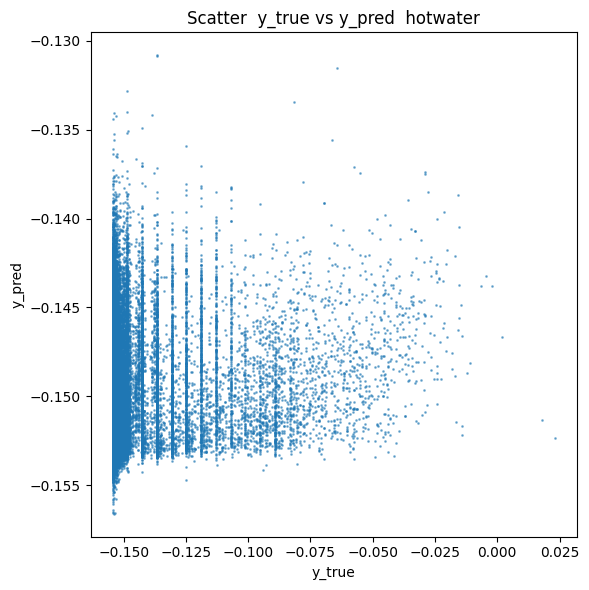

In [28]:
# 11. meter_type별 산점도 y_true vs y_pred
# 상위 K개 meter만 그린다
if "preds" in dfs and not dfs["preds"].empty:
    d = dfs["preds"].copy()
    top_k = 4
    meters = d["meter_type"].value_counts().index.tolist()[:top_k]
    for mtype in meters:
        dm = d[d["meter_type"] == mtype][["y_true", "y_pred"]].dropna()
        if len(dm) == 0:
            continue
        max_points = 100000
        if len(dm) > max_points:
            dm = dm.sample(max_points, random_state=42)
        plt.figure(figsize=(6, 6))
        plt.scatter(dm["y_true"], dm["y_pred"], s=1, alpha=0.5)
        plt.title(f"Scatter  y_true vs y_pred  {mtype}")
        plt.xlabel("y_true")
        plt.ylabel("y_pred")
        plt.tight_layout()
        plt.show()


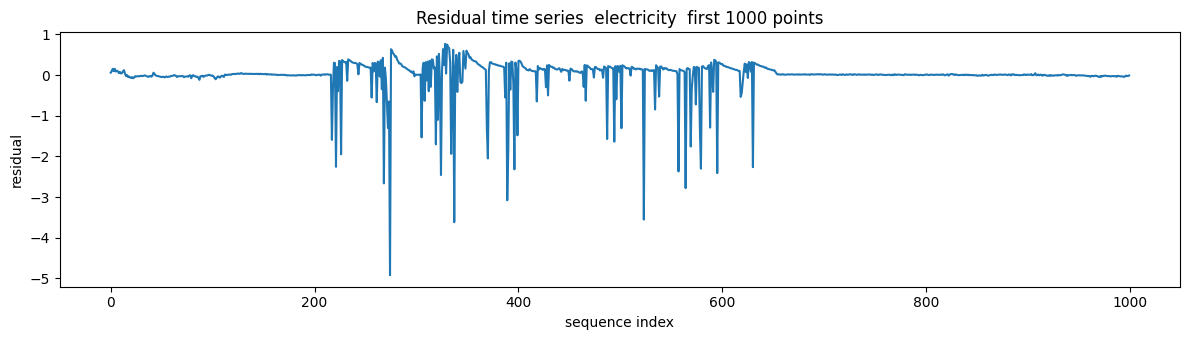

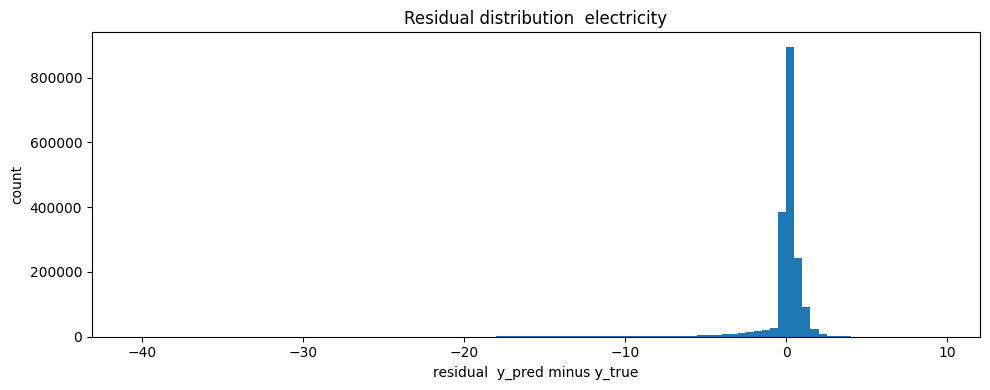

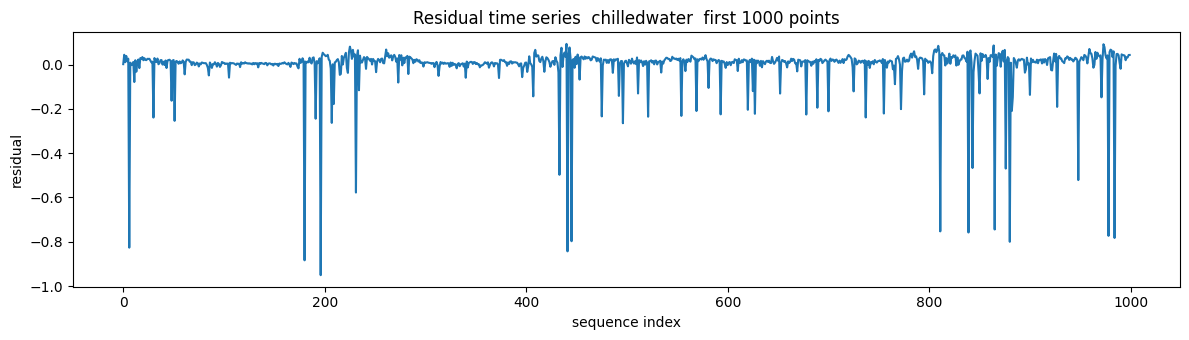

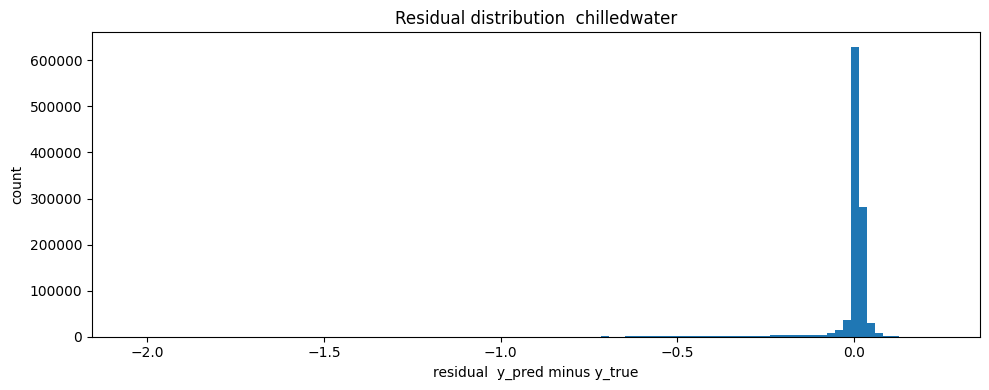

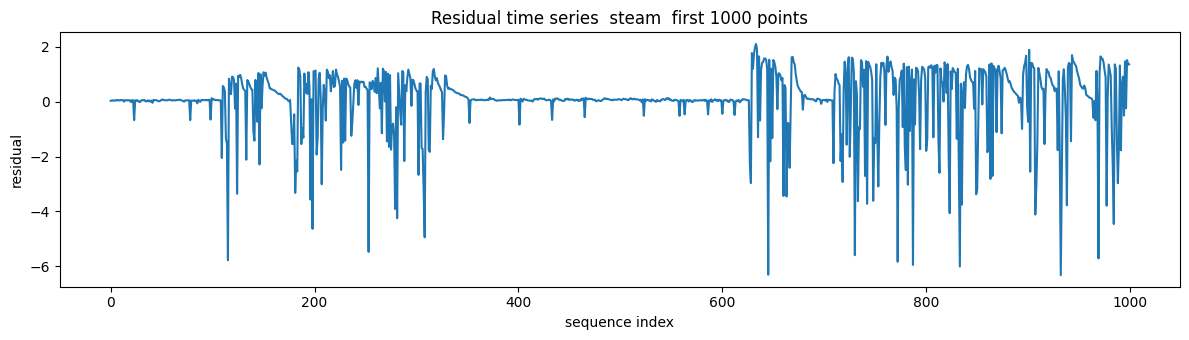

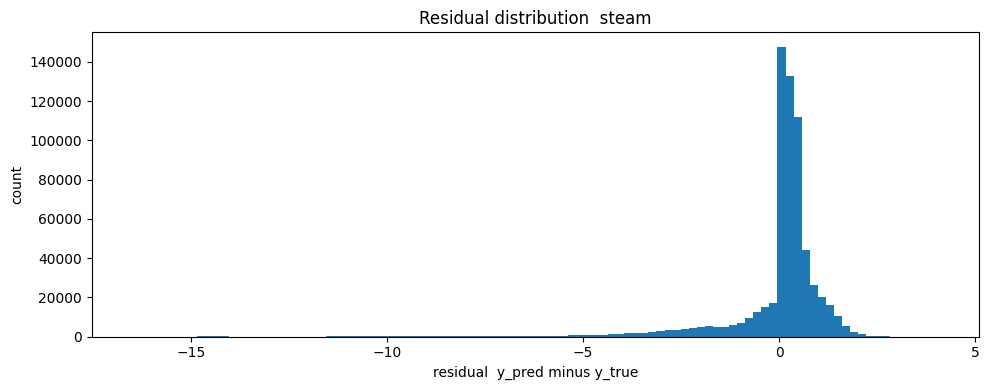

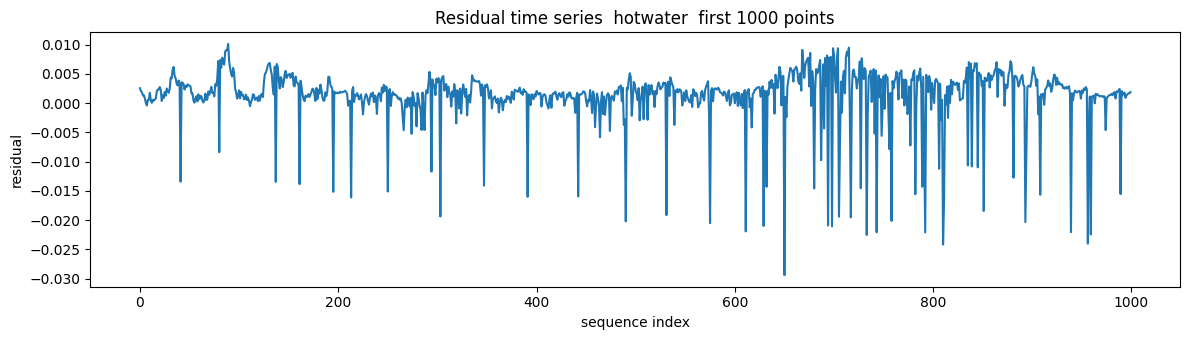

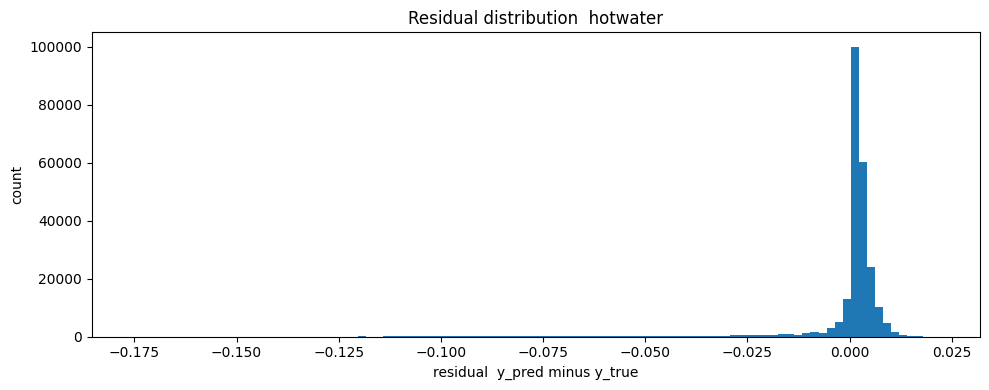

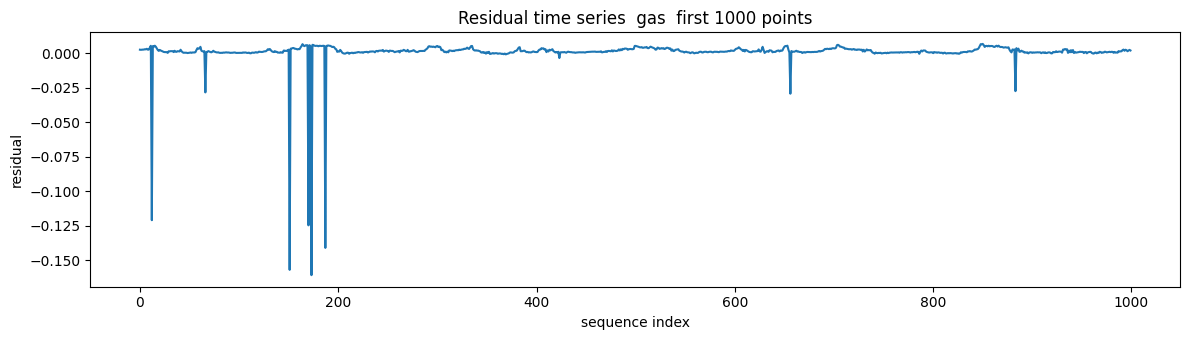

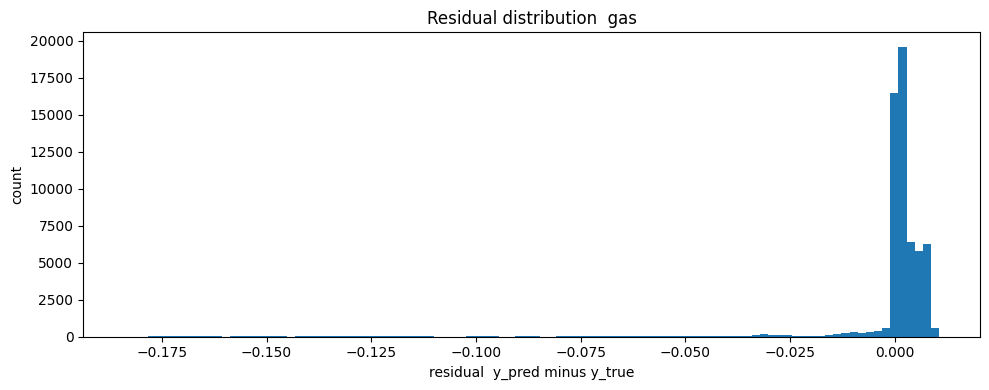

In [29]:
# 12. 잔차 분석
# 잔차 라인플롯과 잔차 히스토그램을 meter별로
if "preds" in dfs and not dfs["preds"].empty:
    d = dfs["preds"].copy()
    meters = d["meter_type"].unique()
    window = 1000
    for mtype in meters:
        dm = d[d["meter_type"] == mtype].sort_values("seq_index").reset_index(drop=True)
        if len(dm) == 0:
            continue
        dm["residual"] = dm["y_pred"] - dm["y_true"]

        # 라인 플롯
        w = min(window, len(dm))
        plt.figure(figsize=(12, 3.5))
        plt.plot(range(w), dm["residual"].iloc[:w])
        plt.title(f"Residual time series  {mtype}  first {w} points")
        plt.xlabel("sequence index")
        plt.ylabel("residual")
        plt.tight_layout()
        plt.show()

        # 히스토그램
        plt.figure(figsize=(10, 4))
        plt.hist(dm["residual"].dropna().values, bins=100)
        plt.title(f"Residual distribution  {mtype}")
        plt.xlabel("residual  y_pred minus y_true")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()
